# Caltech101 – CNN Training and Performance Assessment

This notebook presents an investigation into image classification utilizing the Caltech101 dataset. The study involves the development and comparative analysis of three convolutional neural network (CNN) architectures:

	1.	A custom-built 3-layer CNN, trained from the ground up
	2.	A ResNet18 model with frozen weights, employed strictly as a feature extractor
	3.	A fine-tuned ResNet18, leveraging pre-trained weights with subsequent parameter optimization

Each model undergoes comprehensive evaluation, encompassing the following metrics and visualizations:

	•	A complete classification performance report
	•	A 101-by-101 confusion matrix
	•	Receiver Operating Characteristic (ROC) and Area Under the Precision-Recall Curve (AUC-PRC) plots
	•	Computation of the Top-1 error rate
	•	Examination of learned convolutional filters and internal feature representations (applicable to the custom CNN)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
import random
import tarfile

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 101_ObjectCategories.tar.gz to 101_ObjectCategories.tar.gz


In [3]:
import tarfile

archive_path = "101_ObjectCategories.tar.gz"
extract_path = "./data/101_ObjectCategories"

# Extract the .tar.gz archive
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path="./data/")

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Define normalization constants for ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transformation pipeline for training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transformation pipeline for validation data
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Load the full Caltech101 dataset
dataset_path = "./data/101_ObjectCategories"
full_dataset = ImageFolder(root=dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)

# Split dataset into training and validation sets (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# Assign transformations to the subsets
train_subset.dataset.transform = train_transforms
val_subset.dataset.transform = val_transforms

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Summary output
print(f"Caltech101 loaded: {num_classes} classes across {len(full_dataset)} images.")

Caltech101 loaded: 102 classes across 9144 images.


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(start_dim=1)  # Flatten all dimensions except batch
        x = self.classifier(x)
        return x

In [6]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=30, patience=5, device='cuda'
):
    model.to(device)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    best_val_acc = 0.0
    best_weights = None
    wait = 0

    for epoch in tqdm(range(num_epochs), desc="Training"):
        # Training Phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)

        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                probs = torch.softmax(outputs, dim=1)

                val_loss += loss.item() * imgs.size(0)
                preds = probs.argmax(dim=1)
                val_correct += (preds == lbls).sum().item()
                val_total += lbls.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        print(f"[{epoch+1}/{num_epochs}] "
              f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        scheduler.step()

        # Check for improvement
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_weights = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping 🛑 — no improvement for {patience} epochs.")
                break

    model.load_state_dict(best_weights)
    return model, history, np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = BasicCNN(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
cnn_model, cnn_history, cnn_y_true, cnn_y_pred, cnn_y_probs = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    patience=5,
    device=device
)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

[1/30] Train Acc: 0.3016 | Val Acc: 0.4188
[2/30] Train Acc: 0.4591 | Val Acc: 0.4839
[3/30] Train Acc: 0.5954 | Val Acc: 0.5599
[4/30] Train Acc: 0.7314 | Val Acc: 0.5511
[5/30] Train Acc: 0.8142 | Val Acc: 0.5670
[6/30] Train Acc: 0.9113 | Val Acc: 0.5872
[7/30] Train Acc: 0.9375 | Val Acc: 0.5910
[8/30] Train Acc: 0.9444 | Val Acc: 0.5916
[9/30] Train Acc: 0.9535 | Val Acc: 0.5943
[10/30] Train Acc: 0.9630 | Val Acc: 0.6003
[11/30] Train Acc: 0.9623 | Val Acc: 0.5981
[12/30] Train Acc: 0.9645 | Val Acc: 0.6003
[13/30] Train Acc: 0.9691 | Val Acc: 0.6003
[14/30] Train Acc: 0.9690 | Val Acc: 0.5981
[15/30] Train Acc: 0.9694 | Val Acc: 0.5981
Early stopping 🛑 — no improvement for 5 epochs.


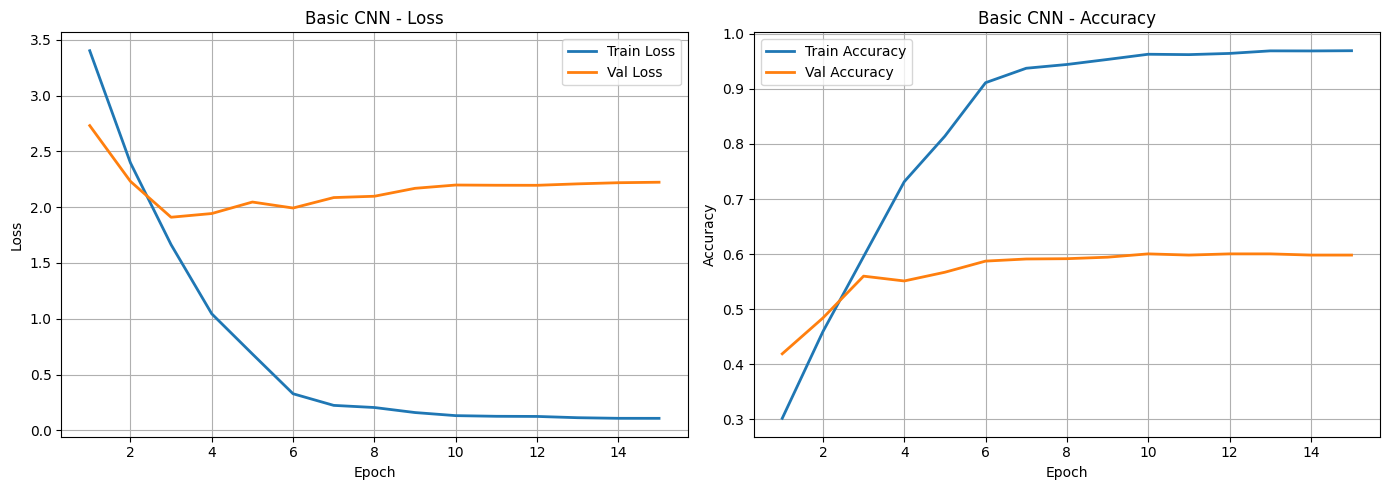

In [8]:
def plot_learning_curves(history, title="BasicCNN Training Progress"):
    import matplotlib.pyplot as plt

    epochs = list(range(1, len(history["train_loss"]) + 1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss Curve
    ax1.plot(epochs, history["train_loss"], label="Train Loss", linewidth=2)
    ax1.plot(epochs, history["val_loss"], label="Val Loss", linewidth=2)
    ax1.set_title(f"{title} - Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Accuracy Curve
    ax2.plot(epochs, history["train_acc"], label="Train Accuracy", linewidth=2)
    ax2.plot(epochs, history["val_acc"], label="Val Accuracy", linewidth=2)
    ax2.set_title(f"{title} - Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(cnn_history, title="Basic CNN")

📋 Classification Report:
                   precision    recall  f1-score   support

BACKGROUND_Google       0.22      0.54      0.31        91
            Faces       0.80      0.95      0.87        82
       Faces_easy       0.95      0.99      0.97        91
         Leopards       0.97      0.97      0.97        39
       Motorbikes       0.95      0.99      0.97       163
        accordion       0.62      0.89      0.73         9
        airplanes       0.89      0.99      0.94       152
           anchor       0.17      0.10      0.12        10
              ant       0.00      0.00      0.00         7
           barrel       0.33      0.10      0.15        10
             bass       0.50      0.09      0.15        11
           beaver       0.40      0.22      0.29         9
        binocular       0.75      0.38      0.50         8
           bonsai       0.54      0.54      0.54        28
            brain       0.52      0.52      0.52        25
     brontosaurus       0.33  

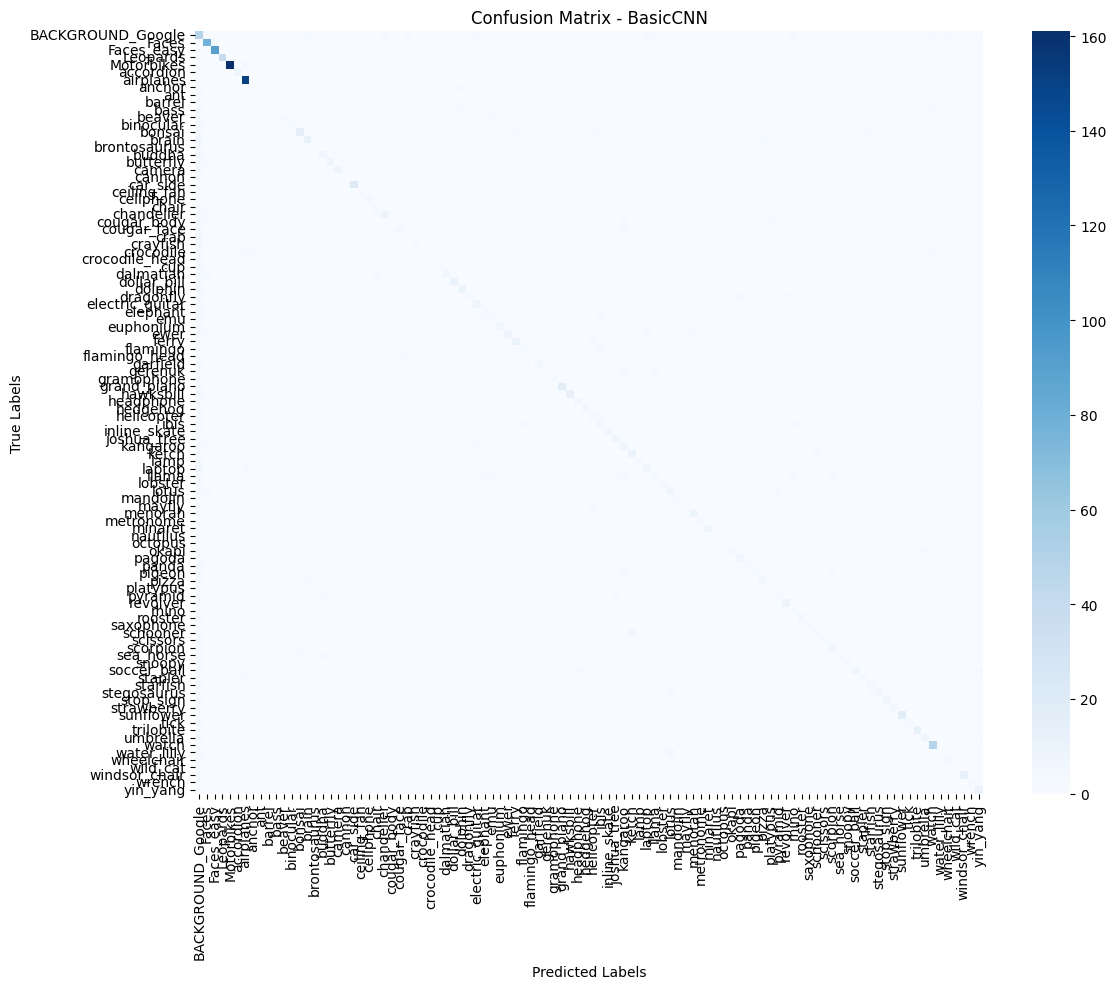

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Report
print("📋 Classification Report:")
print(classification_report(cnn_y_true, cnn_y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(cnn_y_true, cnn_y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - BasicCNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

🎯 Top-1 Error Rate: 40.19%


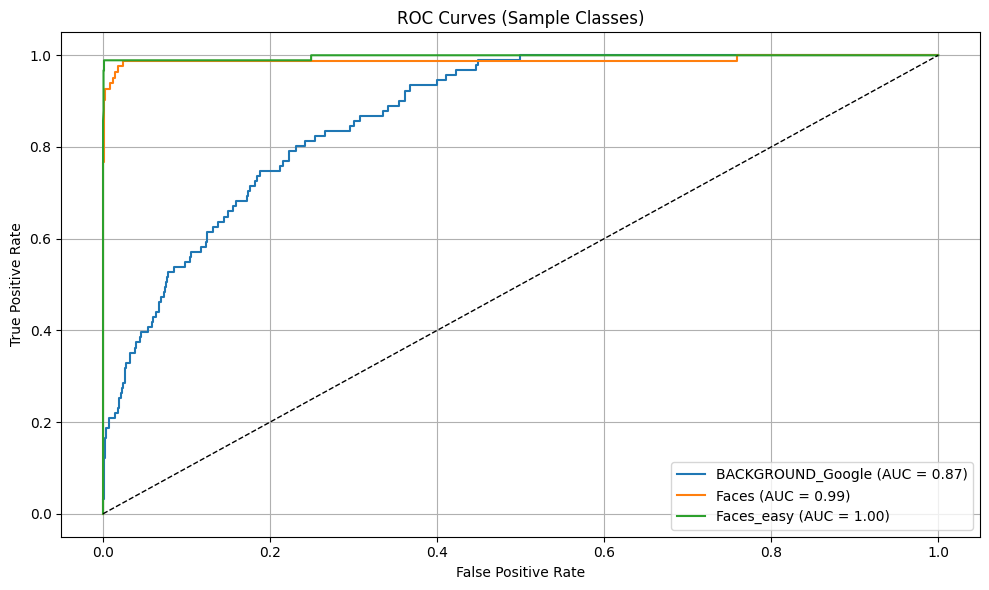

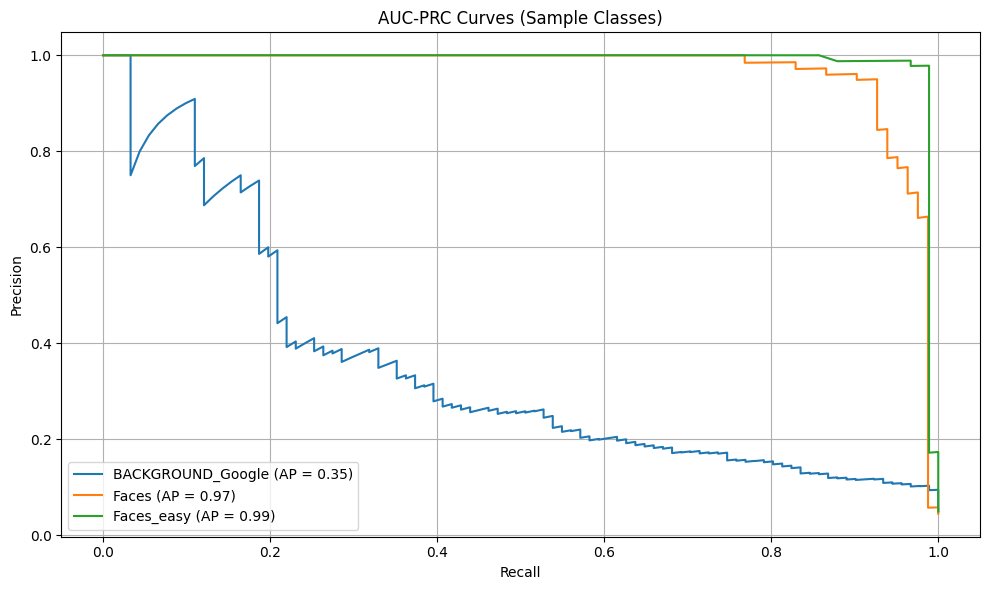

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt

# Top-1 Error Rate
accuracy = np.mean(cnn_y_true == cnn_y_pred)
top1_error = (1 - accuracy) * 100
print(f"🎯 Top-1 Error Rate: {top1_error:.2f}%")

# Binarize labels for multi-class ROC/PRC
y_true_bin = label_binarize(cnn_y_true, classes=np.arange(num_classes))

# ROC Curve computation
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], cnn_y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves for first 3 classes
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Sample Classes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# AUC-PRC computation
precision, recall, prc_auc = {}, {}, {}
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], cnn_y_probs[:, i])
    prc_auc[i] = average_precision_score(y_true_bin[:, i], cnn_y_probs[:, i])

# Plot AUC-PRC Curves for first 3 classes
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {prc_auc[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUC-PRC Curves (Sample Classes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18 model
frozen_resnet = models.resnet18(pretrained=True)

# Freeze all layers to use as a fixed feature extractor
for param in frozen_resnet.parameters():
    param.requires_grad = False

# Replace the classification head with a new trainable layer
num_features = frozen_resnet.fc.in_features
frozen_resnet.fc = nn.Linear(num_features, num_classes)

# Now only the new fully connected layer is trainable

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


In [12]:
# Move model to the selected device
frozen_resnet.to(device)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer: only train the final classification layer
optimizer = optim.Adam(frozen_resnet.fc.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
# Train the frozen ResNet18 model (feature extractor mode)
frozen_resnet, frozen_history, frozen_y_true, frozen_y_pred, frozen_y_probs = train_model(
    model=frozen_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    patience=5,
    device=device
)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

[1/30] Train Acc: 0.6206 | Val Acc: 0.8513
[2/30] Train Acc: 0.8930 | Val Acc: 0.8824
[3/30] Train Acc: 0.9295 | Val Acc: 0.8901
[4/30] Train Acc: 0.9457 | Val Acc: 0.9032
[5/30] Train Acc: 0.9605 | Val Acc: 0.9071
[6/30] Train Acc: 0.9753 | Val Acc: 0.9081
[7/30] Train Acc: 0.9788 | Val Acc: 0.9087
[8/30] Train Acc: 0.9787 | Val Acc: 0.9103
[9/30] Train Acc: 0.9806 | Val Acc: 0.9103
[10/30] Train Acc: 0.9810 | Val Acc: 0.9092
[11/30] Train Acc: 0.9805 | Val Acc: 0.9092
[12/30] Train Acc: 0.9805 | Val Acc: 0.9081
[13/30] Train Acc: 0.9825 | Val Acc: 0.9098
Early stopping 🛑 — no improvement for 5 epochs.


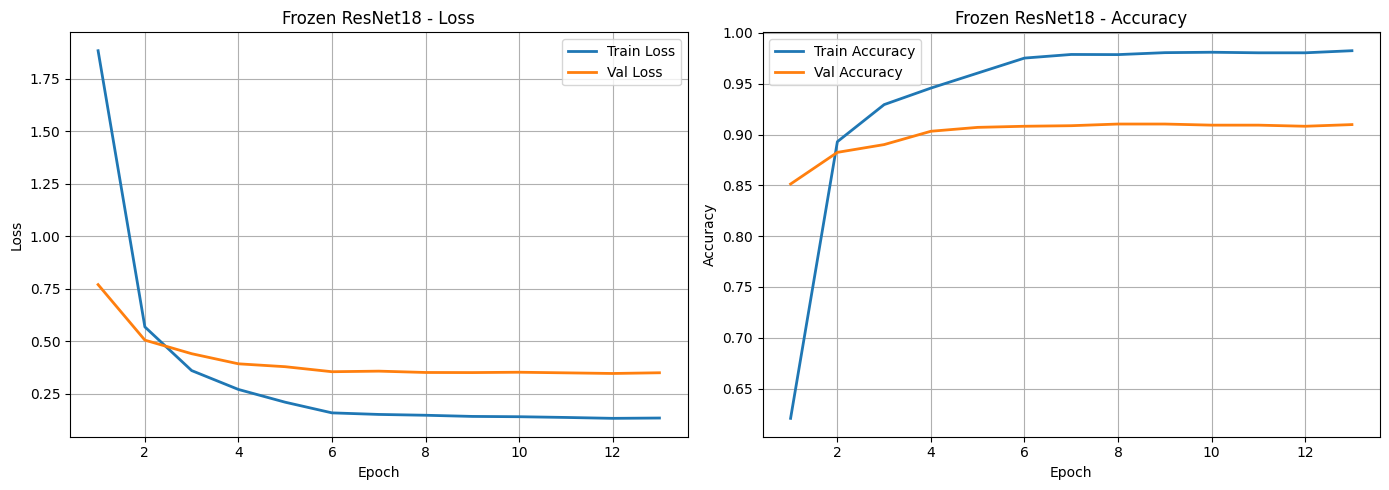

In [14]:
plot_learning_curves(frozen_history, title='Frozen ResNet18')

📋 Classification Report (ResNet18 - Frozen Features):
                   precision    recall  f1-score   support

BACKGROUND_Google       0.67      0.75      0.70        91
            Faces       0.95      0.99      0.97        82
       Faces_easy       0.99      0.97      0.98        91
         Leopards       0.97      1.00      0.99        39
       Motorbikes       0.98      1.00      0.99       163
        accordion       1.00      1.00      1.00         9
        airplanes       0.97      1.00      0.98       152
           anchor       0.75      0.60      0.67        10
              ant       0.57      0.57      0.57         7
           barrel       1.00      0.90      0.95        10
             bass       1.00      0.55      0.71        11
           beaver       0.89      0.89      0.89         9
        binocular       0.78      0.88      0.82         8
           bonsai       0.90      0.96      0.93        28
            brain       0.92      0.96      0.94        25
 

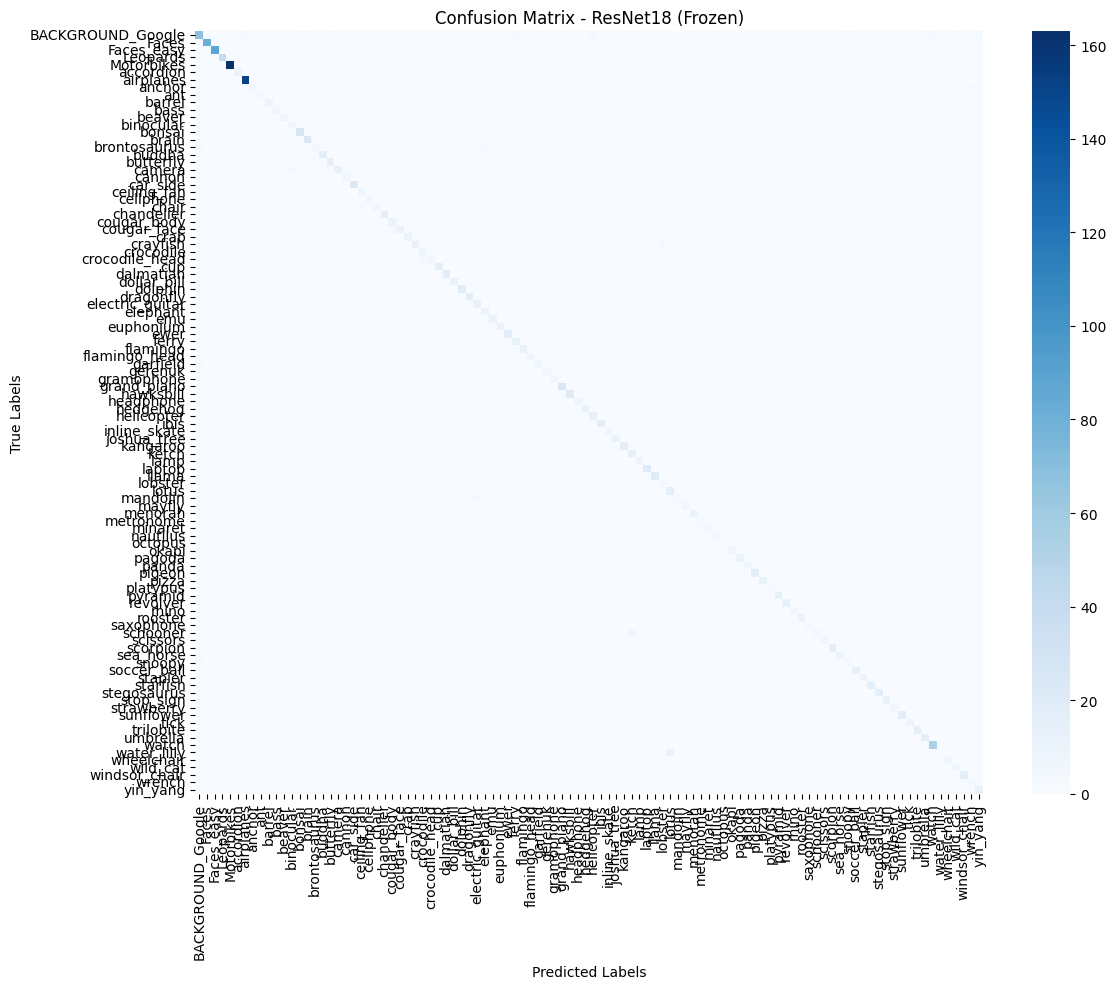

In [15]:
# Classification Report
print("📋 Classification Report (ResNet18 - Frozen Features):")
print(classification_report(frozen_y_true, frozen_y_pred, target_names=class_names))

# Confusion Matrix
frozen_cm = confusion_matrix(frozen_y_true, frozen_y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(frozen_cm, annot=False, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - ResNet18 (Frozen)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

🎯 Top-1 Error Rate (ResNet18 - Frozen): 9.02%


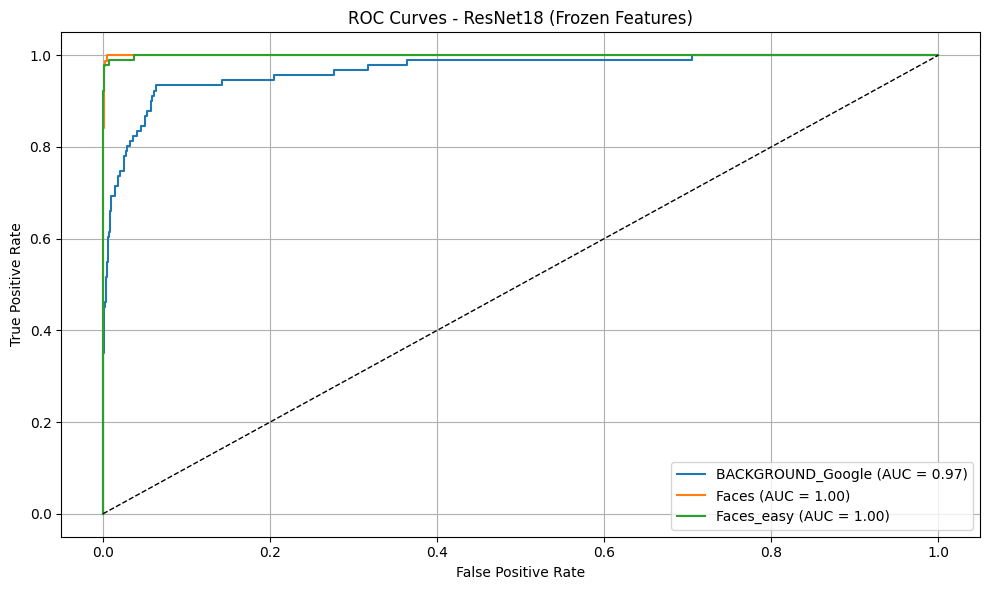

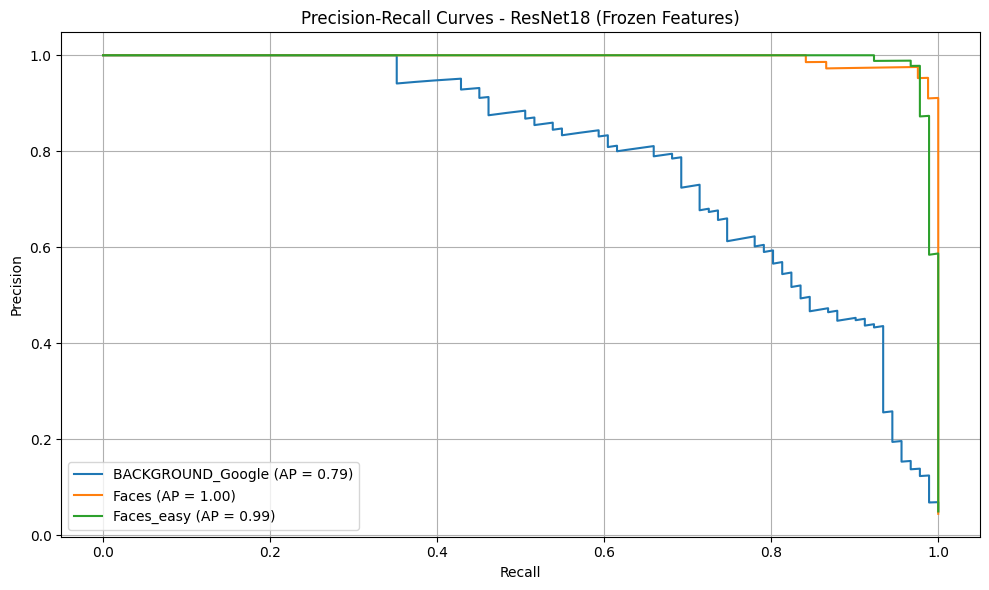

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt

# Top-1 Error Rate
frozen_accuracy = np.mean(frozen_y_true == frozen_y_pred)
frozen_top1_error = (1 - frozen_accuracy) * 100
print(f"🎯 Top-1 Error Rate (ResNet18 - Frozen): {frozen_top1_error:.2f}%")

# Binarize labels
frozen_y_true_bin = label_binarize(frozen_y_true, classes=np.arange(num_classes))

# ROC Curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(frozen_y_true_bin[:, i], frozen_y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves for 3 sample classes
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ROC Curves - ResNet18 (Frozen Features)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# PRC Curves
precision, recall, prc_auc = {}, {}, {}
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(frozen_y_true_bin[:, i], frozen_y_probs[:, i])
    prc_auc[i] = average_precision_score(frozen_y_true_bin[:, i], frozen_y_probs[:, i])

# Plot PRC Curves for 3 sample classes
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {prc_auc[i]:.2f})')

plt.title("Precision-Recall Curves - ResNet18 (Frozen Features)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Load pretrained ResNet18 for fine-tuning (all layers trainable)
tuned_resnet = models.resnet18(pretrained=True)

# Replace the classification head
num_features = tuned_resnet.fc.in_features
tuned_resnet.fc = nn.Linear(num_features, num_classes)

# Move to device
tuned_resnet = tuned_resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer: all parameters are trainable
optimizer = optim.Adam(tuned_resnet.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
# Train the fine-tuned ResNet18 model
tuned_resnet, tuned_history, tuned_y_true, tuned_y_pred, tuned_y_probs = train_model(
    model=tuned_resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    patience=5,
    device=device
)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

[1/30] Train Acc: 0.7042 | Val Acc: 0.8978
[2/30] Train Acc: 0.9646 | Val Acc: 0.9382
[3/30] Train Acc: 0.9951 | Val Acc: 0.9453
[4/30] Train Acc: 0.9989 | Val Acc: 0.9492
[5/30] Train Acc: 0.9999 | Val Acc: 0.9431
[6/30] Train Acc: 0.9999 | Val Acc: 0.9492
[7/30] Train Acc: 0.9999 | Val Acc: 0.9486
[8/30] Train Acc: 0.9999 | Val Acc: 0.9470
[9/30] Train Acc: 0.9999 | Val Acc: 0.9497
[10/30] Train Acc: 0.9999 | Val Acc: 0.9513
[11/30] Train Acc: 0.9997 | Val Acc: 0.9508
[12/30] Train Acc: 0.9999 | Val Acc: 0.9519
[13/30] Train Acc: 0.9999 | Val Acc: 0.9502
[14/30] Train Acc: 0.9999 | Val Acc: 0.9513
[15/30] Train Acc: 0.9999 | Val Acc: 0.9508
[16/30] Train Acc: 0.9999 | Val Acc: 0.9513
[17/30] Train Acc: 0.9999 | Val Acc: 0.9513
Early stopping 🛑 — no improvement for 5 epochs.


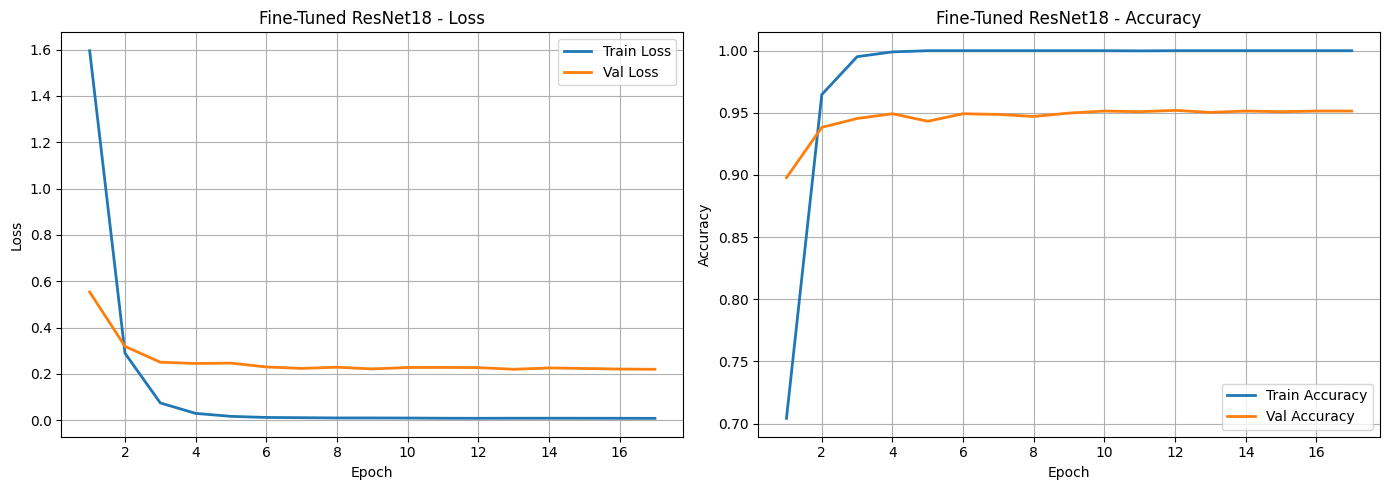

In [20]:
plot_learning_curves(tuned_history, title='Fine-Tuned ResNet18')

📋 Classification Report (ResNet18 - Fine-Tuned):
                   precision    recall  f1-score   support

BACKGROUND_Google       0.86      0.82      0.84        91
            Faces       0.98      0.99      0.98        82
       Faces_easy       0.99      0.98      0.98        91
         Leopards       1.00      1.00      1.00        39
       Motorbikes       0.99      1.00      1.00       163
        accordion       1.00      1.00      1.00         9
        airplanes       1.00      1.00      1.00       152
           anchor       1.00      0.90      0.95        10
              ant       0.83      0.71      0.77         7
           barrel       1.00      0.90      0.95        10
             bass       0.90      0.82      0.86        11
           beaver       0.78      0.78      0.78         9
        binocular       1.00      0.88      0.93         8
           bonsai       1.00      1.00      1.00        28
            brain       0.92      0.96      0.94        25
     b

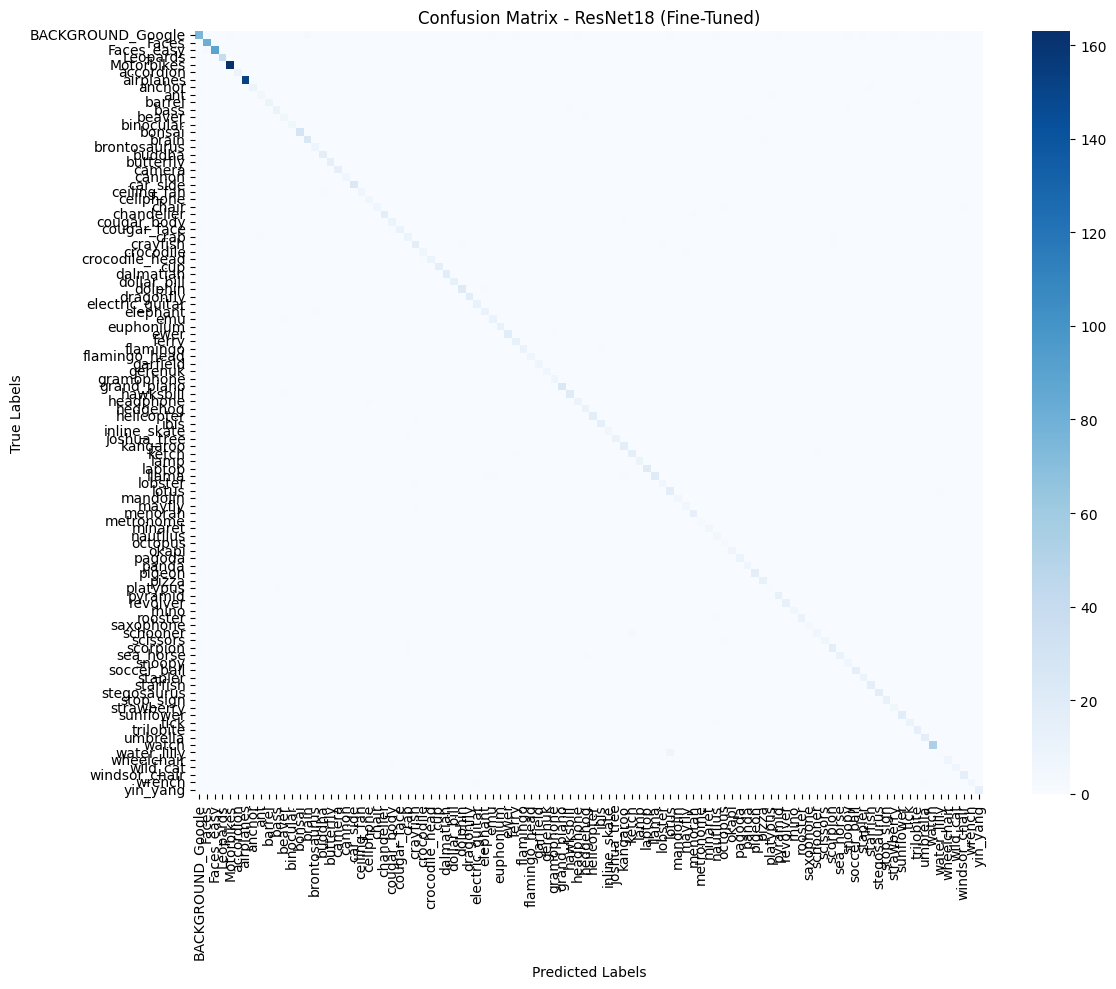

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Report
print("📋 Classification Report (ResNet18 - Fine-Tuned):")
print(classification_report(tuned_y_true, tuned_y_pred, target_names=class_names))

# Confusion Matrix
tuned_cm = confusion_matrix(tuned_y_true, tuned_y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(tuned_cm, annot=False, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - ResNet18 (Fine-Tuned)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

🎯 Top-1 Error Rate (ResNet18 - Fine-Tuned): 4.87%


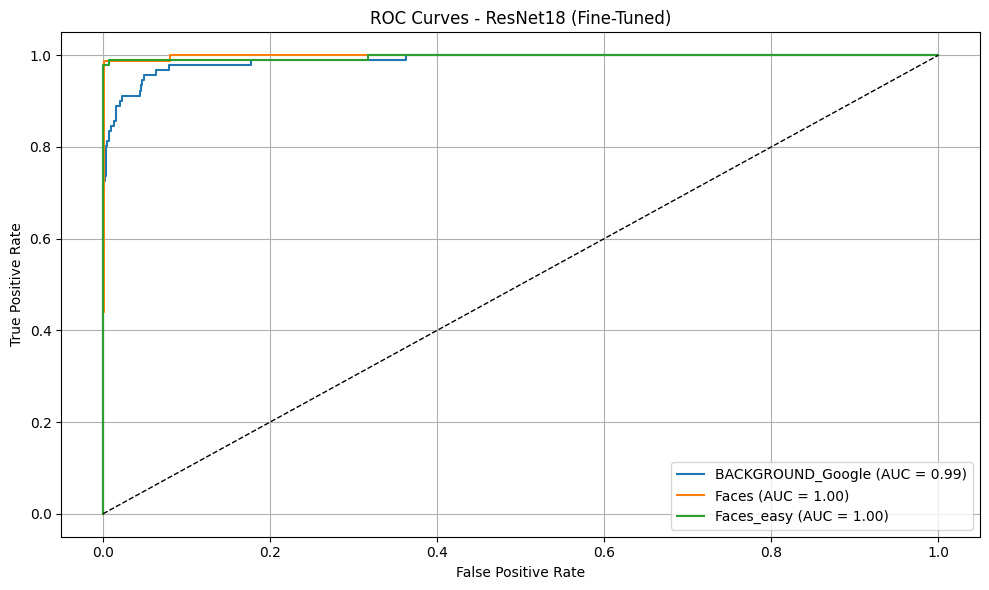

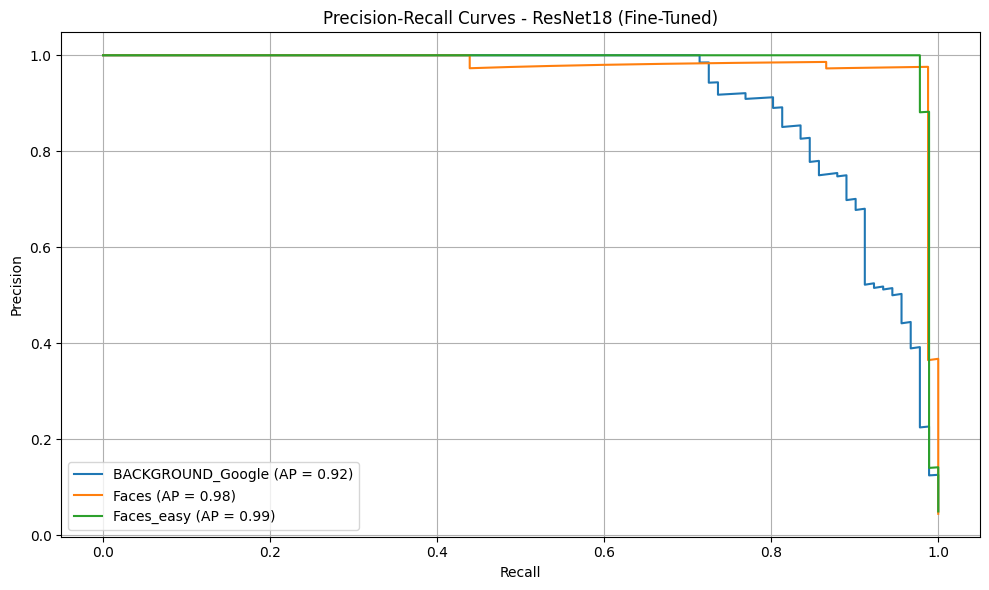

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt

# Top-1 Error Rate
tuned_accuracy = np.mean(tuned_y_true == tuned_y_pred)
tuned_top1_error = (1 - tuned_accuracy) * 100
print(f"🎯 Top-1 Error Rate (ResNet18 - Fine-Tuned): {tuned_top1_error:.2f}%")

# Binarize true labels
tuned_y_true_bin = label_binarize(tuned_y_true, classes=np.arange(num_classes))

# ROC Curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(tuned_y_true_bin[:, i], tuned_y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves (first 3 classes)
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ROC Curves - ResNet18 (Fine-Tuned)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curves
precision, recall, prc_auc = {}, {}, {}
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(tuned_y_true_bin[:, i], tuned_y_probs[:, i])
    prc_auc[i] = average_precision_score(tuned_y_true_bin[:, i], tuned_y_probs[:, i])

# Plot PRC Curves (first 3 classes)
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {prc_auc[i]:.2f})')

plt.title("Precision-Recall Curves - ResNet18 (Fine-Tuned)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

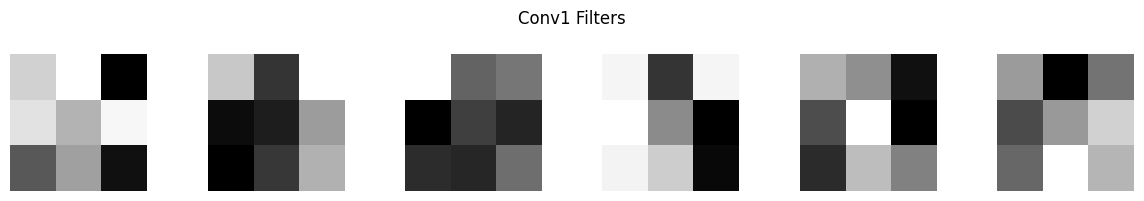

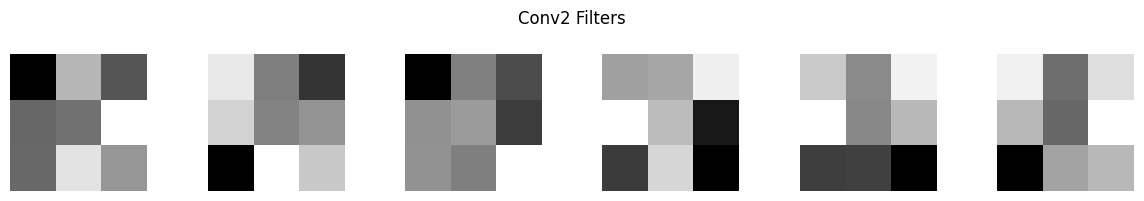

In [23]:
def visualize_filters(tensor, title, num_filters=6):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, num_filters, figsize=(num_filters * 2, 2))
    for i in range(num_filters):
        f = tensor[i].detach().cpu().numpy()
        # For RGB input: [out_channels, in_channels, H, W]
        # For grayscale display: show the first input channel
        axes[i].imshow(f[0], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_filters(cnn_model.features[0].weight, title="Conv1 Filters")
visualize_filters(cnn_model.features[3].weight, title="Conv2 Filters")

In [ ]:
def visualize_feature_maps(model, input_image, layer_indices=[0, 3]):
    import matplotlib.pyplot as plt

    model.eval()
    x = input_image.unsqueeze(0).to(next(model.parameters()).device)

    feature_maps = []
    with torch.no_grad():
        for i, layer in enumerate(model.features):
            x = layer(x)
            if i in layer_indices:
                feature_maps.append(x.cpu())

    for idx, fmap in enumerate(feature_maps):
        fmap = fmap.squeeze(0)  # Remove batch dimension
        num_channels = min(6, fmap.shape[0])
        fig, axes = plt.subplots(1, num_channels, figsize=(num_channels * 2, 2))
        for i in range(num_channels):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')
        plt.suptitle(f"Feature Maps after Conv Layer {idx+1}")
        plt.tight_layout()
        plt.show()

sample_img, _ = val_subset[0]
sample_img = val_transforms(sample_img)
visualize_feature_maps(cnn_model, sample_img, layer_indices=[0, 3])

4.1 What kind of features did the filters learn to extract?

	•	In BasicCNN, the early layers learned to detect simple patterns like edges, textures, and basic shapes. Deeper layers captured more complex features such as object parts or structured patterns.
	•	In the frozen ResNet, filters retained their general-purpose nature from ImageNet—detecting common visual patterns like corners, blobs, and textures that transfer well across datasets.
	•	In the fine-tuned ResNet, filters adapted to Caltech101, focusing on class-specific details like unique textures, contours, and object-specific shapes.

4.2 Are there “blind” filters that didn’t learn anything? Why? How to fix it?

Yes, some filters—especially in BasicCNN—likely remained inactive or underutilized. This can happen due to poor initialization, redundant filters, or weak regularization. It can be improved by reducing model size, applying better initialization, or using batch normalization.

4.3 Does the model consider the background of the inputs?

Yes, to some extent. The model may use background cues if they are consistent within a class (e.g., birds against the sky). This is more evident in simpler models. The fine-tuned ResNet is better at focusing on relevant object regions rather than relying on the background.

4.4 Does the model consider the color of the inputs?

Yes. All models process color images (3 channels), and color is often an important feature—especially for classes with distinctive color patterns (e.g., zebra, sunflower). However, over-reliance on color may hurt performance under varying lighting or conditions.